In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import backend as K
from tensorflow import keras
from tensorflow.errors import InvalidArgumentError
import tensorflow as tf

# Tensorflow GPU settings
# gpu_options = tf.GPUOptions(allow_growth=True)#per_process_gpu_memory_fraction=0.5)
# sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn import preprocessing
from sklearn.utils import shuffle

from scipy import interpolate

from atlasify import atlasify
import pickle
import os

import sys
sys.path.append('../')
import plot_util
import util

2022-03-14 15:09:17.409992: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-03-14 15:09:18.172614: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-03-14 15:09:18.173862: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-03-14 15:09:18.189511: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:65:00.0 name: Quadro RTX 4000 computeCapability: 7.5
coreClock: 1.545GHz coreCount: 36 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 387.49GiB/s
2022-03-14 15:09:18.189560: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-03-14 15:09:18.192799: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-0

In [16]:
# Note that we are loading the FULL signal and background datasets
sig = pd.read_feather('/home/grabanal/WVZ/gabriel_ML_data/20220301_ELReLMIs54_MUReLMIs31_btag77_VVZ.arrow')
sig['source'] = 'Signal'
sig['is_signal'] = True
# bg = pd.read_feather(('/home/grabanal/WVZ/gabriel_ML_data/'
#                            + '20220301_ELReLMIs54_MUReLMIs31_btag77_FULLBG.arrow'))
# bg['is_signal'] = False

In [17]:
bg_others = pd.read_feather(('/home/grabanal/WVZ/gabriel_ML_data/'
                             + '20220301_ELReLMIs54_MUReLMIs31_btag77_others.arrow'))
bg_others['source'] = 'Other'

bg_ttZ = pd.read_feather(('/home/grabanal/WVZ/gabriel_ML_data/'
                          + '20220301_ELReLMIs54_MUReLMIs31_btag77_ttZ.arrow'))
bg_ttZ['source'] = 'ttZ'

bg_tWZ = pd.read_feather(('/home/grabanal/WVZ/gabriel_ML_data/'
                          + '20220301_ELReLMIs54_MUReLMIs31_btag77_tWZ.arrow'))
bg_tWZ['source'] = 'tWZ'

bg_tZ = pd.read_feather(('/home/grabanal/WVZ/gabriel_ML_data/'
                         + '20220301_ELReLMIs54_MUReLMIs31_btag77_tZ.arrow'))
bg_tZ['source'] = 'tZ'

bg_WZ = pd.read_feather(('/home/grabanal/WVZ/gabriel_ML_data/'
                         + '20220301_ELReLMIs54_MUReLMIs31_btag77_WZ.arrow'))
bg_WZ['source'] = 'WZ'

bg_Zgamma = pd.read_feather(('/home/grabanal/WVZ/gabriel_ML_data/'
                             + '20220301_ELReLMIs54_MUReLMIs31_btag77_Zgamma.arrow'))
bg_Zgamma['source'] = 'Z + gamma'

bg_Zjets = pd.read_feather(('/home/grabanal/WVZ/gabriel_ML_data/'
                            + '20220301_ELReLMIs54_MUReLMIs31_btag77_Zjets.arrow'))
bg_Zjets['source'] = 'Z + jets'

bg_ZZ = pd.read_feather(('/home/grabanal/WVZ/gabriel_ML_data/'
                         + '20220301_ELReLMIs54_MUReLMIs31_btag77_ZZ.arrow'))
bg_ZZ['source'] = 'ZZ'

bg = pd.concat([bg_others, bg_ttZ, bg_tWZ, bg_tZ, bg_WZ, bg_Zgamma, bg_Zjets, bg_ZZ])
bg['is_signal'] = False

In [18]:
train_feats = sorted([f for f in sig.columns if f not in ['index', 'wgt', 'is_signal', 
                                                          'v_j_btag77', 'v_j_btag60', 
                                                          'v_j_btag85', 'v_j_btagCont', 'v_j_btag70', 
                                                          'source']])
print('Using the following training features:')
print(sorted(train_feats))

Using the following training features:
['HT', 'MET', 'METPhi', 'METSig', 'Njet', 'Nlep', 'SR', 'Wlep1_ambiguous', 'Wlep1_dphi', 'Wlep1_eta', 'Wlep1_phi', 'Wlep1_pid', 'Wlep1_pt', 'Wlep2_ambiguous', 'Wlep2_dphi', 'Wlep2_eta', 'Wlep2_phi', 'Wlep2_pid', 'Wlep2_pt', 'Zcand_mass', 'Zlep1_ambiguous', 'Zlep1_dphi', 'Zlep1_eta', 'Zlep1_phi', 'Zlep1_pid', 'Zlep1_pt', 'Zlep2_ambiguous', 'Zlep2_dphi', 'Zlep2_eta', 'Zlep2_phi', 'Zlep2_pid', 'Zlep2_pt', 'chisq', 'eta_1', 'eta_2', 'eta_3', 'eta_4', 'jet_btagCont_1', 'jet_btagCont_2', 'jet_btagCont_3', 'jet_btagCont_4', 'jet_eta_1', 'jet_eta_2', 'jet_eta_3', 'jet_eta_4', 'jet_m_1', 'jet_m_2', 'jet_m_3', 'jet_m_4', 'jet_phi_1', 'jet_phi_2', 'jet_phi_3', 'jet_phi_4', 'jet_pt_1', 'jet_pt_2', 'jet_pt_3', 'jet_pt_4', 'lep1_ambiguous', 'lep1_pid', 'lep2_ambiguous', 'lep2_pid', 'lep3_ambiguous', 'lep3_pid', 'lep4_ambiguous', 'lep4_pid', 'leptonic_HT', 'mass_4l', 'other_mass', 'phi_1', 'phi_2', 'phi_3', 'phi_4', 'pt_1', 'pt_2', 'pt_3', 'pt_4', 'pt_4l', 'tota

In [19]:
# Normalize training features
X = pd.concat([sig[train_feats], bg[train_feats]], ignore_index=True)

min_max_scaler = preprocessing.MinMaxScaler()

min_max_scaler.fit(X)

for df in [sig, bg]:
    df[train_feats] = min_max_scaler.transform(df[train_feats])

In [20]:
# Cut to 4l-SF (in Z) signal region
bg = bg[bg.SR == 0]
sig = sig[sig.SR == 0]

# Setup k-folds

In [21]:
combined_data = pd.concat([sig[train_feats + ['wgt', 'is_signal', 'source']], 
                           bg[train_feats + ['wgt', 'is_signal', 'source']]], 
                          ignore_index=True)
combined_labels = np.concatenate([np.ones(len(sig)), np.zeros(len(bg))])

In [22]:
K_FOLDS = 5
k_folder = StratifiedKFold(n_splits = K_FOLDS, random_state=314, shuffle=True)

# Assign k-folds
combined_data['k_fold'] = -1
for i, (_, test_index) in enumerate(k_folder.split(combined_data, combined_labels)):
    combined_data.loc[test_index, 'k_fold'] = i

# Train models

In [ ]:
EPOCHS = 10000
PATIENCE = 200
BATCH_SIZE = 1024
NUM_NODES = 64
DROPOUT = 0.1
LEARN_RATE = 1e-5

def make_model(input_dim, num_nodes, dropout, learn_rate):
    # Generate and fit model
    K.clear_session()
    classifier = Sequential()
    classifier.add(Dense(num_nodes, input_dim=input_dim, activation='relu')) 
    classifier.add(Dropout(dropout))
    classifier.add(Dense(num_nodes, activation='relu'))
    classifier.add(Dropout(dropout))
    classifier.add(Dense(num_nodes, activation='relu'))
    classifier.add(Dropout(dropout))
    classifier.add(Dense(1, activation='sigmoid'))

    opt = keras.optimizers.Adam(learning_rate=learn_rate)
    classifier.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    
    return classifier

models = [None] * K_FOLDS

for k in range(K_FOLDS):
    # Generate train and validation samples
    # The test sample has k-index k
    # The validation sample has k-index k - 1
    # The rest is for training
    val_k_index = k - 1
    if val_k_index < 0:
        val_k_index = K_FOLDS - 1
        
    x_val = combined_data[combined_data.k_fold == val_k_index]
    y_val = combined_labels[combined_data.k_fold == val_k_index]
    w_val = np.abs(x_val.wgt)
    
    x_train = combined_data[(combined_data.k_fold != k)&(combined_data.k_fold != val_k_index)]
    y_train = combined_labels[(combined_data.k_fold != k)&(combined_data.k_fold != val_k_index)]
    
    n_train_sig = sum(x_train[y_train == 1].wgt)
    n_train_bg = sum(x_train[y_train == 0].wgt)
    
    sig_correction = (n_train_sig + n_train_bg) / (2 * n_train_sig)
    bg_correction = (n_train_sig + n_train_bg) / (2 * n_train_bg)
    w_train = (sig_correction * y_train + bg_correction * (1 - y_train)) * np.abs(x_train.wgt)
    
    # Restrict to training features
    x_train = x_train[train_feats]
    x_val = x_val[train_feats]
    
    # Generate and fit model
    classifier = make_model(input_dim=x_train.shape[1], num_nodes=NUM_NODES, 
                            dropout=DROPOUT, learn_rate=LEARN_RATE)
    
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=PATIENCE, 
                                                   restore_best_weights=True)

    history = classifier.fit(x_train, y_train, sample_weight=w_train, 
                             validation_data=(x_val, y_val, w_val),
                             epochs=EPOCHS, batch_size=BATCH_SIZE,
                             verbose=1, callbacks=[es_callback], shuffle=True)
    
    # Save model and history
    model_dir = 'models/SR_SF_inZ/'
    model_name = 'classifier_abs_wgt_k_' + str(k)
    if not os.path.exists(model_dir):
        os.makedirs(model_dir)
        
    classifier.save(model_dir + model_name)
    with open(model_dir + model_name + '_history.pkl', 'wb') as file_pi:
        pickle.dump(history.history, file_pi)

# Analyze results

In [ ]:
# Generate training history plots
for k in range(K_FOLDS):
    # Load model
    model_dir = 'models/SR_SF_inZ/'
    plot_dir = 'plots/SR_SF_inZ/'
    model_name = 'classifier_abs_wgt_k_' + str(k)
    
    with open(model_dir + model_name + '_history.pkl', 'rb') as f:
        history = pickle.load(f)
        
    # Loss
    plt.plot(history['loss'], label='loss')
    plt.plot(history['val_loss'], label='val loss')
    
    plt.legend(fontsize=12)
    plt.xlabel('NN output', fontsize=12)
    plt.ylabel('Density', fontsize=12)
    
    atlasify('Internal simulation', outside=True)
    
    plt.title('4$\ell$-SF (in Z) history\nk = ' + str(k), fontsize=14, loc='right')
    
    plot_util.save_fig(plot_dir, model_name + '_loss')
    plt.show()
    
    # Accuracy
    plt.plot(history['accuracy'], label='acc')
    plt.plot(history['val_accuracy'], label='val acc')
    
    plt.legend(fontsize=12)
    plt.xlabel('NN output', fontsize=12)
    plt.ylabel('Density', fontsize=12)
    
    atlasify('Internal simulation', outside=True)
    
    plt.title('4$\ell$-SF (in Z) history\nk = ' + str(k), fontsize=14, loc='right')
    
    plot_util.save_fig(plot_dir, model_name + '_acc')
    plt.show()

In [23]:
nn_out_col = 'nn_out'

combined_data[nn_out_col] = -1

for k in range(K_FOLDS):
    # Load model
    model_dir = 'models/SR_SF_inZ/'
    model_name = 'classifier_abs_wgt_k_' + str(k)
    
    K.clear_session()
    classifier = keras.models.load_model(model_dir + model_name)
    
    # We test classifier k on slice k
    x_test = combined_data[combined_data.k_fold == k][train_feats]
    combined_data.loc[combined_data.k_fold == k, nn_out_col] = classifier.predict(x_test, batch_size=10000)

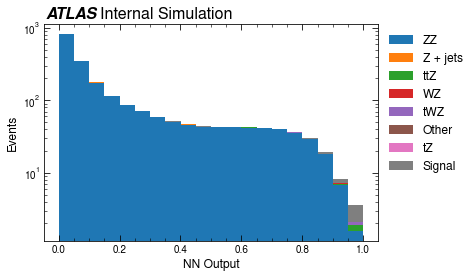

In [62]:
bg_sample = combined_data[combined_data.is_signal == 0]
sig_sample = combined_data[combined_data.is_signal == 1]

bg_ZZ_sample = bg_sample[bg_sample.source == 'ZZ']
bg_Zjets_sample = bg_sample[bg_sample.source == 'Z + jets']
bg_ttZ_sample = bg_sample[bg_sample.source == 'ttZ']
bg_WZ_sample = bg_sample[bg_sample.source == 'WZ']
bg_tWZ_sample = bg_sample[bg_sample.source == 'tWZ']
bg_other_sample = bg_sample[bg_sample.source == 'Other']
# bg_Zgamma_sample = bg_sample[bg_sample.source == 'Z + gamma']
bg_tZ_sample = bg_sample[bg_sample.source == 'tZ']

plot_util.make_nn_output_source_plot(bg_ZZ_sample, bg_Zjets_sample, bg_ttZ_sample, 
                                     bg_WZ_sample, bg_tWZ_sample, bg_other_sample, 
                                     bg_tZ_sample,
                                     sig_sample, column='nn_out', bins=20, log=True, 
                                     save=True, 
                                     save_dir='plots/SR_SF_inZ/', save_name='nn_output_density_stacked')

In [ ]:
bg_sample = combined_data[combined_data.is_signal == 0]
sig_sample = combined_data[combined_data.is_signal == 1]


plot_util.make_nn_output_plot(bg_sample, sig_sample, 'nn_out', 'Background', 'Signal', 
                              save=True, save_dir='plots/SR_SF_inZ/', save_name='nn_output', 
                              title='4$\ell$-SF (in Z)', log=True)
plot_util.make_nn_output_plot(bg_sample, sig_sample, 'nn_out', 'Background', 'Signal', density=True, 
                              save=True, save_dir='plots/SR_SF_inZ/', save_name='nn_output_density', 
                              title='4$\ell$-SF (in Z)', log=False)

In [ ]:
n_cuts = 100

cuts = np.arange(0, 1, 1./n_cuts)
sigs = [-1]*n_cuts

max_sig = -1
max_sig_loc = -1

for i, nn_cut in enumerate(cuts):
    bg_sample = combined_data[(combined_data.is_signal == 0)&(combined_data.nn_out >= nn_cut)]
    sig_sample = combined_data[(combined_data.is_signal == 1)&(combined_data.nn_out >= nn_cut)]

    n_sig = sum(sig_sample.wgt)
    n_bg = sum(bg_sample.wgt)

    sig = util.significance(n_sig, n_bg)
    sigs[i] = sig
    if sig > max_sig:
        max_sig = sig
        max_sig_loc = nn_cut

In [ ]:
# Plot scan
plt.figure(figsize=(6, 4))
plt.plot(cuts, sigs)

plt.axhline(y=max_sig, color='black', ls='--', alpha=0.5)
plt.axvline(x=max_sig_loc, color='black', ls='--', alpha=0.5)

plt.ylabel('Significance', fontsize=14)
plt.xlabel('NN cut', fontsize=14)
plt.title('4$\ell$-SF (in Z)', loc='right', fontsize=14)

plt.text(min(cuts), min(sigs), 
         'Max: %.2f $\sigma$\nLoc: %.2f'%(max_sig, max_sig_loc),
         fontsize=14)

atlasify('Internal Simulation', outside=True)

plot_util.save_fig('plots/SR_SF_inZ/', 'sig_scan')